<a href="https://colab.research.google.com/github/jgomezpe/evoluo/blob/master/chavela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with the Hybrid Adaptive Evolutionary Algorithm (HAEA) for Natural Computing Journal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


royalroad-GGA-


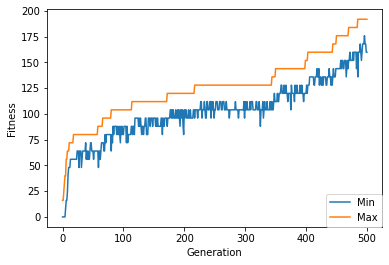

royalroad-GGA--avg


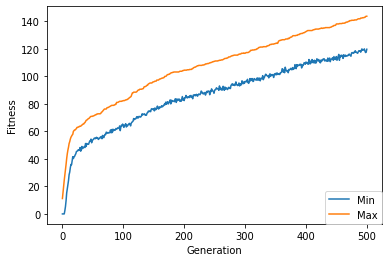

[  500.         35120.73333333   119.73333333   143.73333333]
*****************************************
royalroad-SSGA-


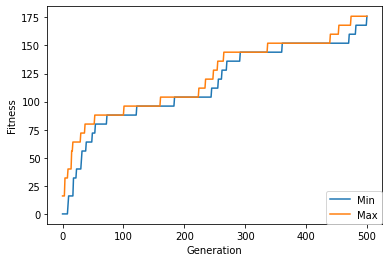

royalroad-SSGA--avg


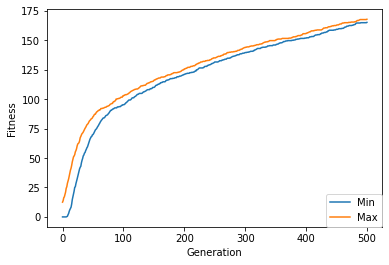

[  500.         35096.53333333   165.06666667   167.73333333]
*****************************************


In [ ]:
import numpy as np
import random as rand

from inspect import signature
import matplotlib.pyplot as plt

############### FUNCTIONS TO BE OPTIMIZED ################
##### Bitstring Testbed #####
# MaxOnes function
def maxones(x):
  return x.count(True)

# Goldberg's 3-Deceptive function
def deceptive(x):
  switcher = {
    0: 28,
    1: 26,
    2: 22,
    3: 0,
    4: 14,
    5: 0,
    6: 0,
    7: 30
  }
  size=3
  c = 0
  i = 0
  while i<len(x):
    end = i+size
    d=0
    b=1
    for k in range(i,end):
      d += b if x[k] else 0
      b *= 2
    c += switcher.get(d, 0)
    i = end  
  return c

# Goldberg's Boundedly-Deceptive function
def boundedly(x):
  size=4
  c = 0
  i = 0
  while i<len(x):
    end = i+size
    u = 0
    for k in range(i,end):
      u += 1 if x[k] else 0
    c += u if u==size else 3-u
    i = end
  return c

# Forrest Royal Road function
def royalroad(x):
  size=8
  c = 0
  i = 0
  while i<len(x):
    end = i+size
    while i<end and x[i]:
      i+=1
    c += size if i==end else 0
    i = end
  return c

##### Realvector Testbed #####
# Scale a realvector
def scale(x, min, max):
  length = max-min
  return [min + length*x[i] for i in range(len(x))]

# Griewank's function (receives a [0,1)**DIM vector and scale it to a [-512,512)**DIM vector)
def griewank(x):
  x = scale(x, -512.0, 512.0)
  sum = 0.0
  prod = 1.0
  for i in range(len(x)):
    sum += ( x[i]**2 ) / 4000.0
    prod *= np.math.cos(x[i] / np.math.sqrt(i+1))
  return 1.0 + sum - prod

# Rastrigin's function (receives a [0,1)**DIM vector and scale it to a [-5.12,5.12)**DIM vector)
def rastrigin(x):
  x = scale(x, -5.12, 5.12)
  f = 10*len(x)
  for i in range(len(x)):
    f += x[i]**2 - (10*np.math.cos(2*np.math.pi*x[i]))
  return f

# Schwefel's function (receives a [0,1)**DIM vector and scale it to a [-512,512)**DIM vector)
def schwefel(x):
  x = scale(x, -512.0, 512.0)
  alpha = 418.982887
  f = 0
  for i in range(len(x)):
    f -= x[i]*np.math.sin(np.math.sqrt(np.math.fabs(x[i])))
  return f + alpha*len(x)

# Rosenbrock's saddle function (receives a [0,1)**DIM vector and scale it to a [-2.048,2.048)**DIM vector)
def rosenbrock(x):
  x = scale(x, -2.048, 2.048)
  f = 0
  for i in range(len(x)-1):
    f += 100*(x[i+1]-x[i]**2)**2+(1-x[i])**2
  return f

##### Permutation Testbed #####
# n-Queens problem 
def queens(x):
  f = 0
  for i in range(0,len(x)-1):
    for j in range(i+1,len(x)):
      f += 1 if abs(x[i]-x[j]) == j-i else 0
  return f

############### Stochastic Global Optimization Algorithm ################

def SGOAL(n):
  global TRACE, stats, STATS, INITPOP, END, NEXTPOP
  t=0
  P = INITPOP(n)
  if TRACE:
    stats.append(STATS(P))
  while not END(P,t):
    P = NEXTPOP(P)
    if TRACE:
      stats.append(STATS(P))
    t = t+1
  return BEST(P)

def LE( x, y ):
  return ORDER(x,y)==x

def LT( x, y ):
  return x!=y and LE(x,y)

def BEST(P):
  global ORDER
  return ORDER( x['fitness'] for x in P ) # An individual in the population has at least solution part and fitness part

############### Stopping Condition ################

def maxiters(P,t):
  global ITERS #Maximum number of iterations
  return t>=ITERS

############### Solution Space ################

# Generates a boolean value according to probability p ( True with probability p, False otherwise )
def randbool(p=0.5):
  return (rand.random() < p)

# A bitstring of length DIM
def bitstring(DIM):
  return [randbool() for i in range(0,DIM)]

# Real vector in the hypercube [0,1)**DIM
def realvector01(DIM):
  return [rand.random() for i in range(0,DIM)]

# A permutation of DIM elements
def permutation(DIM):
  x = [i for i in range(0,DIM)]
  rand.shuffle(x)
  return x

def eval(x):
  global TRACE, FVALS, F
  f = F(x)
  if TRACE:
    FVALS.append(f)
  return f

############### Init Population Method ################

# Basic Init population, for speed reasons the fitness is kept by each individual
def BASICINITPOP(n):
  global SPACE, DIM
  P = []
  for i in range(0,n):
    x = SPACE(DIM)
    P.append({'solution':x, 'fitness':eval(x)})
  return P

# The Init population for HAEA
# Normalizes a vector of weights
def normalize(weight):
  c = 0
  for w in weight:
    c += w
  p = np.empty(len(weight))
  for i in range(0,len(p)):
    p[i] = weight[i] / c
  return p  

# Init Rates - individual level
def initrates(m):
  rate = np.empty(m)
  for i in range(0,m):
    rate[i] = rand.random()
    while rate[i] == 0:
      rate[i] = rand.random()
  return normalize(rate)    

def HAEAINITPOP(n):
  global SPACE, DIM, OPERS
  P = []
  for i in range(0,n):
    x = SPACE(DIM)
    P.append({'solution':x, 'fitness':eval(x), 'rates':initrates(len(OPERS))})
  return P

############### Next Population Method ################


############### Selection Mechanism ################
# Uniform selection
def raw_uniform(M, n):
  return [rand.randint(0,M) for i in range(0,n)]

def uniform(quality, n):
  return raw_uniform(len(quality)-1, n)

# Roulette selection
def weighted(p):
  y = rand.random()
  k=0
  while k<len(p) and y>=p[k]:
    y -= p[k]
    k+=1
  return k

def roulette(quality, n):
  p = normalize(quality)
  return [ weighted(p) for i in range(0,n) ]

# Tournament selection. Selects n individuals. 
# For each individual to be selected this method picks 4 individuals and returns the best of those
def tournament1(quality):
  m = 4 #Tournament's size
  candidate = uniform(quality,m)
  x = 0
  for k in range(1,m):
    if LE(quality[candidate[k]], quality[candidate[x]]):
      x = k
  return candidate[x]

def tournament(quality, n):
  return [ tournament1(quality) for i in range(0,n) ]

############### Genetic Operators ################
# Bitstring mutation with probability 1/length(parent)
def BM(parent):
  child = parent.copy()
  p = 1.0/len(child)
  for i in range(0,len(child)):
    if randbool(p):
      child[i] = not child[i]
  return child

# Gaussian mutation with sigma = 0.2 and probability 1/length(parent)
def GM(parent):
  child = parent.copy()
  p = 1.0/len(child)
  for i in range(0,len(child)):
    if randbool(p):
      child[i] = min(max(rand.gauss(child[i], 0.2), 0.0), 1.0)
  return child

# swap mutation with probability 1/length(parent)
def SM(parent):
  child = parent.copy()
  p = 1.0/len(child)
  for i in range(0,len(child)):
    if randbool(p):
      j = rand.randint(0,len(child)-1)
      child[i], child[j] = child[j], child[i]
  return child

# Transposition genetic operator 
def T(parent):
  child = parent.copy()
  start = rand.randint(0,len(child)-1)
  end = rand.randint(0,len(child)-1)
  if start>end:
    t = start
    start = end
    end = t
  while start<end:
    x = child[start]
    child[start] = child[end]
    child[end] = x
    start += 1
    end -= 1
  return child

# Partial order crossover
def POX(parent1, parent2):
  pc = rand.randint(1,len(parent1)-1)
  child1 = list(parent1[0:pc])
  for x in parent2:
    if x not in child1:
      child1.append(x)
  child2 = list(parent2[0:pc])
  for x in parent1:
    if x not in child2:
      child2.append(x)
  return [child1, child2]

# Single point crossover
def SPX(parent1, parent2):
  pc = rand.randint(1,len(parent1)-1)
  child11 = list(parent1[0:pc])
  child12 = list(parent2[pc:len(parent2)])
  child21 = list(parent2[0:pc])
  child22 = list(parent1[pc:len(parent1)])
  child1 = child11 + child12
  child2 = child21 + child22
  return [child1, child2]

# Single point crossover
def XM(parent1, parent2):
  global XOVER, MUTATION
  c1, c2 = XOVER(parent1,parent2)
  return [MUTATION(c1), MUTATION(c2)]

# Arity of the genetic operator f
def arity(f):
  return len(signature(f).parameters)

############### Generational Genetic Algorithm - GGA ################
def fitness(P):
  return [x['fitness'] for x in P]

def GGA(P):
  global ORDER, SELECT, MUTATION, XOVER, cr
  n = len(P)
  Q = []
  fP = fitness(P)
  for i in range(0,n,2):
    idx1, idx2 = SELECT(fP, 2)
    if rand.random() < cr:
      a, b = XOVER(P[idx1]['solution'], P[idx2]['solution'])
      a = MUTATION(a)
      b = MUTATION(b)
      Q.append( {'solution':a, 'fitness':eval(a)} )
      Q.append( {'solution':b, 'fitness':eval(b)} )
    else:
      Q.append( P[idx1] )
      Q.append( P[idx2] )
  return Q

############### Steady State Genetic Algorithm - SSGA ################
def best2( c1, c2, a, f1, f2, fa):
  if LE(fa,f1):
    return a, c1, fa, f1
  else:
    if LE(fa,f2):
      return c1, a, f1, fa
    else:
      return c1, c2, f1, f2

def SSGA(P):
  global MUTATION, XOVER, cr
  n = len(P)
  fP = fitness(P)
  for i in range(0,n,2):
    idx1, idx2 = uniform(fP, 2)
    if rand.random() < cr:
      if LE(fP[idx1], fP[idx2]):
        c1 = P[idx1]['solution']
        c2 = P[idx2]['solution']
        f1 = fP[idx1]
        f2 = fP[idx2]
      else:
        c1 = P[idx2]['solution']
        c2 = P[idx1]['solution']
        f1 = fP[idx2]
        f2 = fP[idx1]

      a, b = XOVER(c1, c2)
      a = MUTATION(a)
      fa = eval(a)
      c1, c2, f1, f2 = best2( c1, c2, a, f1, f2, fa)
      b = MUTATION(b)
      fb = eval(b)
      c1, c2, f1, f2 = best2( c1, c2, b, f1, f2, fb)
      P[idx1] = {'solution':c1, 'fitness':f1}
      P[idx2] = {'solution':c2, 'fitness':f2}
      fP[idx1] = f1
      fP[idx2] = f2
  return P

############### Hybrid Adaptive Evolutionary Algorithm - HAEA ################
# Update rates
def updaterates(h, fc, fp, rate):
  delta = rand.random()
  if LT(fc,fp):
    rate[h] *= (1.0+delta)
  else:
    rate[h] *= (1.0-delta)
  return normalize(rate) 

def IndexBest(fP):
  global ORDER
  idx = 0
  for i in range(1,len(fP)):
    if LE(fP[i], fP[idx]):
      idx = i
  return idx

def GCHAVELA( p, fp, c, fc ):
  return [c,fc]

def SSCHAVELA( p, fp, c, fc ):
  if LE(fc,fp):
    return c, fc
  else:
    return p, fp


def CHAVELAIND( P, fP, i ):
  global ORDER, OPERS, EXTRA_PARENTS, PICK, REPLACE
  ind = P[i]
  S = ind['solution']
  f = ind['fitness']
  R = ind['rates']
  h = weighted( R )
  parents = [S]
  a = arity(OPERS[h]) 
  if a > 1: 
    idxparents = EXTRA_PARENTS(fP,a-1)
    for k in idxparents:
      parents.append(P[k]['solution'])     
  offspring = OPERS[h](*parents)
  if a == 1:
      offspring = [offspring]
  if PICK.__name__ != 'uniform':
    for k in range(0,len(offspring)):
      offspring[k] = {'solution':offspring[k], 'fitness':eval(offspring[k])}
    qo = fitness(offspring)
    idx = PICK(qo,1)[0]
    c = offspring[idx]['solution']
    fc = qo[idx]
  else:
    c = offspring[PICK(offspring,1)[0]]
    fc = eval(c)
  R = updaterates(h,fc,f,R)
  c, fc = REPLACE(S,f,c,fc)
  return {'solution':c, 'fitness':fc, 'rates':R}
  #else:
  #  return {'solution':S, 'fitness':f, 'rates':R}

# HAEA
def CHAVELA( P ):
  Q = []
  fP = fitness(P)
  for i in range(0,len(P)):
    Q.append(CHAVELAIND(P, fP, i))
  return Q


############### Tracing, Statistics and Plotting ################
# Tracing the SGOAL's evolution
stats = []
FVALS = []
TRACE = True
def init():
  global stats, FVALS
  stats = []
  FVALS = []

# Write Statistics
#Basic statistics
def basicstats(P):
  global stats
  fP = fitness(P)
  b = min(fP)
  w = max(fP)
  s = np.empty(4)
  s[0] = len(stats)
  s[1] = len(FVALS)
  s[2] = b
  s[3] = w
  return s

# HAEA Operators statistics
def rates(P):
  return [x['rates'] for x in P]

def opersstats( rates ):
  m = len(rates[0])
  avg = np.empty(m)
  for h in range(0,m):
    avg[h] = 0
    for i in range(0,len(rates)):
      avg[h] += rates[i][h]
    avg[h] /= len(rates) 
  return avg 

# HAEA Statistics 
def chavelastats(P):
  s = basicstats(P)
  avg = opersstats(rates(P))
  return np.concatenate((s, avg))

#Experiment statistics
exp_stats = []
def initexp():
  global exp_stats, stats
  exp_stats = stats

def addexp():
  global exp_stats, stats
  for i in range(0,len(stats)):
    for j in range(0,len(stats[i])):
      exp_stats[i][j] += stats[i][j]

def avgexp(experiments):
  global exp_stats
  for i in range(0,len(exp_stats)):
    for j in range(0,len(exp_stats[i])):
      exp_stats[i][j] /= experiments

# Plotting
def column( M, k ):
  x = np.empty(len(M))
  for i in range(0,len(M)):
    x[i] = M[i][k]
  return x

def statsplot( M, ylabel, cols, legend, name, values ): 
  global SPACE, ORDER
  global PATH
  x = np.empty(len(M))
  for i in range(0,len(x)):
    x[i] = i
  y = np.empty(len(M))
  for c in range(0,len(cols)):
    for i in range(0,len(x)):
      y[i] = M[i][cols[c]] 
    plt.plot(x, y, label=legend[c])
  plt.xlabel( 'Generation')  
  plt.ylabel( ylabel )  
  if SPACE.__name__ == 'realvector01' and values:
    plt.yscale('log')
  if ORDER.__name__ == 'min':
    plt.legend( loc='upper right', borderaxespad=0.)
  else:
    plt.legend( loc='lower right', borderaxespad=0.)
  plt.savefig(PATH+name)
  plt.show()

############### Experiment ################
def experiment( method, args ):
  global N, NEXTPOP, EXPERIMENTS, F, OPERS
  NEXTPOP = method
  name = F.__name__ + '-' + NEXTPOP.__name__ + '-' + args
  init()
  SGOAL(N)
  print(name)
  statsplot(stats, 'Fitness', [2, 3], ['Min', 'Max'], name, True)
  if NEXTPOP.__name__=='CHAVELA':
    statsplot(stats, 'Operators', [x for x in range(4,len(stats[0]))], [ x.__name__ for x in OPERS], name+'-opers', False)
  initexp()
  for i in range(1,EXPERIMENTS):
    init()
    SGOAL(N)
    addexp()
  avgexp(EXPERIMENTS)
  print(name+'-avg')
  statsplot(exp_stats, 'Fitness', [2, 3], ['Min', 'Max'], name+'-avg', True)
  if NEXTPOP.__name__=='CHAVELA':
    statsplot(exp_stats, 'Operators', [x for x in range(4,len(stats[0]))], [ x.__name__ for x in OPERS], name+'-avg-opers', False)
  print( exp_stats[len(exp_stats)-1] )
  print("*****************************************")

def experimentchavela(rep):
  global OPERS, MUTATION, XOVER
  OPERS = [XM]
  experiment( CHAVELA, rep+'-x')
  OPERS = [MUTATION, XOVER]
  experiment( CHAVELA, rep+'-MX')
  OPERS = [MUTATION, XOVER, T]
  experiment( CHAVELA, rep+'-MXT')

def experimentset( f ):
  global F, INITPOP, STATS, SELECT, PICK, EXTRA_PARENTS, REPLACE, cr, ITERS
  F = f
  INITPOP = BASICINITPOP
  cr = 0.7
  
  STATS = basicstats
  SELECT = tournament
  experiment(GGA, '')
  experiment(SSGA, '')
 
  STATS = chavelastats
  ITERS = (ITERS * 7)//10 #Same number of fitness evaluations  
  INITPOP = HAEAINITPOP
  PICK = uniform
  EXTRA_PARENTS = tournament
  REPLACE = GCHAVELA
  experimentchavela('GEN')
  EXTRA_PARENTS = uniform
  REPLACE = SSCHAVELA
  experimentchavela('SS')
  EXTRA_PARENTS = tournament
  REPLACE = SSCHAVELA
  experimentchavela('HAEA')


#Bitstring Space. f can be: maxones, deceptive, boundedly, or royalroad 
def bitstringexp( f ):
  global ORDER, DIM, SPACE, F, MUTATION, XOVER, ITERS
  ORDER = max
  F = f 
  DIM = 240
  SPACE = bitstring
  MUTATION = BM
  XOVER = SPX
  ITERS = 500
  experimentset(f)

def bitstringtest():
  bitstringexp(maxones)
  bitstringexp(deceptive)
  bitstringexp(boundedly)
  bitstringexp(royalroad)

#Realvector space. f can be griewank, schwefel, rastrigin, rosenbrock
def realexp( f ):
  global ORDER, DIM, SPACE, F, MUTATION, XOVER, ITERS
  ORDER = min
  F = f 
  DIM = 10
  SPACE = realvector01  
  MUTATION = GM
  XOVER = SPX
  ITERS = 1000
  experimentset(f)

def realtest():
  realexp(griewank)
  realexp(schwefel)
  realexp(rastrigin)
  realexp(rosenbrock)

#Combinatorial space
def combinatorialtest():
  global ORDER, DIM, SPACE, F, MUTATION, XOVER, ITERS
  ORDER = min
  F = queens 
  DIM = 40
  SPACE = permutation
  MUTATION = SM
  XOVER = POX
  ITERS = 500
  experimentset(F)

############### Main ################
PATH = "drive/My Drive/HAEA/IMAGES/"
EXPERIMENTS = 30
N = 100
END = maxiters
bitstringtest()
realtest()


